In [ ]:
!cp -r '/content/drive/My Drive/COVID_19_CNN/dataset/COVID' '/content'

In [ ]:
!cp -r '/content/drive/My Drive/COVID_19_CNN/dataset/non-COVID' '/content'

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D,Activation,MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


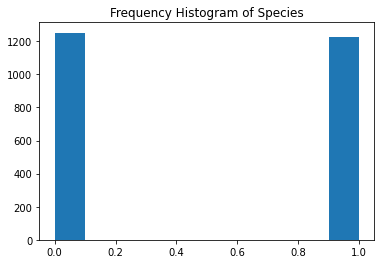

<Figure size 864x864 with 0 Axes>

In [ ]:

disease_types=['COVID', 'non-COVID']
data_dir = '/content'
train_dir = os.path.join(data_dir)

train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()


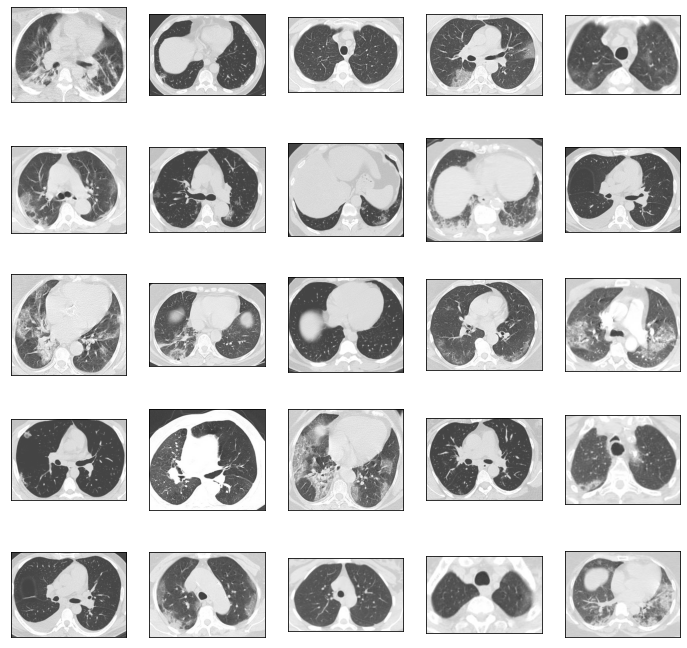

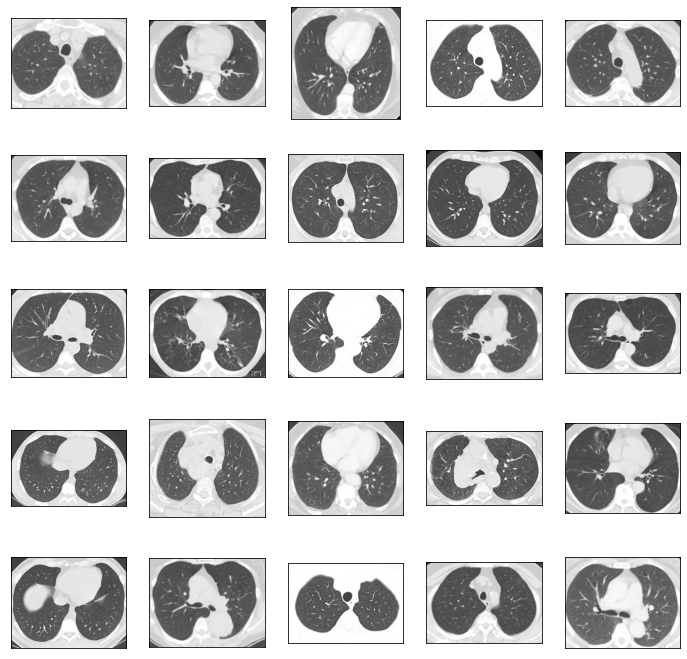

In [ ]:

def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 5, 5)


def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('non-COVID', 5, 5)



2481it [00:14, 171.85it/s]


Train Shape: (2481, 224, 224, 3)


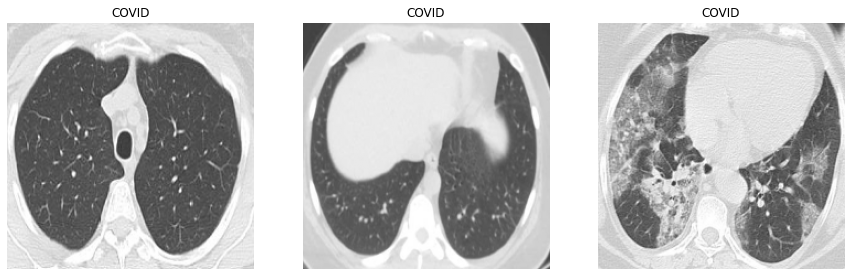

In [ ]:

IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)


X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)


BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)


fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

EPOCHS = 50
SIZE=224
N_ch=3




In [ ]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model


In [ ]:

from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

def build_alexnet():
    #Instantiate an empty model
        model = Sequential()

        # 1st Convolutional Layer
        model.add(Conv2D(filters=32, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
        model.add(Activation('relu'))
        # Max Pooling
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

        # 2nd Convolutional Layer
        model.add(Conv2D(filters=48, kernel_size=(11,11), strides=(1,1), padding='valid'))
        model.add(Activation('relu'))
        # Max Pooling
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

        # 3rd Convolutional Layer
        model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid'))
        model.add(Activation('relu'))

        # 4th Convolutional Layer
        model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid'))
        model.add(Activation('relu'))

        # 5th Convolutional Layer
        model.add(Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), padding='valid'))
        model.add(Activation('relu'))
        # Max Pooling
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

        # Passing it to a Fully Connected layer
        model.add(Flatten())
        # 1st Fully Connected Layer
        model.add(Dense(512))
        model.add(Activation('relu'))
        # Add Dropout to prevent overfitting
        model.add(Dropout(0.4))

        # 2nd Fully Connected Layer
        model.add(Dense(512))
        model.add(Activation('relu'))
        # Add Dropout
        model.add(Dropout(0.4))

        # 3rd Fully Connected Layer
        model.add(Dense(256))
        model.add(Activation('relu'))
        # Add Dropout
        model.add(Dropout(0.4))

        # Output Layer
        model.add(Dense(2))
        model.add(Activation('softmax'))

        model.summary()

        # Compile the model
        model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model


In [ ]:

model = build_alexnet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))




Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 54, 54, 32)        11648     
_________________________________________________________________
activation_19 (Activation)   (None, 54, 54, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 17, 17, 48)        185904    
_________________________________________________________________
activation_20 (Activation)   (None, 17, 17, 48)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 6, 6, 64)         

KeyboardInterrupt: ignored

In [ ]:

#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))


Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)


# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/kaggle/input/sarscov2-ctscan-dataset/SARS-Cov-2/COVID/Covid (1010).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/kaggle/input/sarscov2-ctscan-dataset/SARS-Cov-2/COVID/Covid (1010).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])
